<a href="https://colab.research.google.com/github/Angel-dash/Abstractive-Text-Summarization/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uncomment the code below if you are running on google colab
If you are running the code on the google colab then you must have the data set on your google drive. Link to the dataset where you can download it form https://drive.google.com/file/d/1CAK0Cj1kNgoZ0FRxwwCflbh-1-hKDPoK/view?usp=sharing



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


In [2]:
#!unzip /content/drive/MyDrive/DL/data.zip # Comment out for niranjan's
!unzip /content/drive/MyDrive/MiniProjectdata/amazon.zip #comment out for Angel's



Archive:  /content/drive/MyDrive/MiniProjectdata/amazon.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [3]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import textwrap
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
#data_train=pd.read_csv('/content/cnn_dailymail/train.csv')
#data_test=pd.read_csv('/content/cnn_dailymail/test.csv')
#data_validation=pd.read_csv('/content/cnn_dailymail/validation.csv')
data=pd.read_csv('/content/Reviews.csv',nrows=100000)

Data preprocessing

In [5]:
#data = pd.concat([data_train, data_test, data_validation ])
df = data

In [6]:
new_df=df.sample(25000)

In [7]:
new_df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
3037,3038,B0052OI128,A256JOUD8X0J7R,"musicfan ""The 80s are my favorite""",0,0,3,1343865600,Okay,"I really liked these cookies when they first came out. But then I got a little tired of them. They have a bit of a gritty texture, and they don't taste the way you hope they will when thinking o..."
42113,42114,B0012DMI1S,ALLW2BESUAPIJ,Dooka,1,1,5,1329523200,Great item!,I bought these markers for my daughter's 4th birthday party. The kids had a lot of fun decorating iced cookies. These markers have no scent or flavor. The colors are brilliant and color like ot...
38241,38242,B000634HD2,A7Q0QEKTKDVQK,"C. Hoyt ""Tree-Hugger""",1,1,5,1312156800,No more allergies!!! :),My pit bull (2 years old) had been suffering from food allergies from approximately 8 months until a couple months ago. She had sores all over her stomach and when it got really bad they would eve...


In [8]:
new_df.shape

(25000, 10)

In [ ]:
#sample=new_df.sample()
#print("****Article****")
#print(sample.article.values)
#print('****Highlights****')
#print(sample.highlights.values)

****Article****


AttributeError: ignored

Checking for Null values


In [9]:
new_df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

Checking for duplicates


In [10]:
new_df.duplicated(subset=['Text']).sum()

893

In [11]:
new_df=new_df.drop_duplicates(subset=['Text'])
new_df.shape

(24107, 10)

In [12]:
new_df.duplicated(subset=['Text']).sum()

0

In [13]:
new_df['Text'][:10]

3037     I really liked these cookies when they first came out.  But then I got a little tired of them.  They have a bit of a gritty texture, and they don't taste the way you hope they will when thinking o...
42113    I bought these markers for my daughter's 4th birthday party.  The kids had a lot of fun decorating iced cookies.  These markers have no scent or flavor.  The colors are brilliant and color like ot...
38241    My pit bull (2 years old) had been suffering from food allergies from approximately 8 months until a couple months ago. She had sores all over her stomach and when it got really bad they would eve...
91133    These made my Mom's day. She LOVES dark chocolate and this was a treasure trove for her and she can't thank me enough for sending these. She says they're smoother, less bitter and less sweet than ...
35155    I have just put my 3rd paella in the oven from packets in this mix. I find it to be just the right amount of seasoning. I have been complimented by my frie

In [14]:
new_df['Text'] = new_df['Text'].str.lower()
new_df['Summary'] = new_df['Summary'].str.lower()

new_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
3037,3038,B0052OI128,A256JOUD8X0J7R,"musicfan ""The 80s are my favorite""",0,0,3,1343865600,okay,"i really liked these cookies when they first came out. but then i got a little tired of them. they have a bit of a gritty texture, and they don't taste the way you hope they will when thinking o..."
42113,42114,B0012DMI1S,ALLW2BESUAPIJ,Dooka,1,1,5,1329523200,great item!,i bought these markers for my daughter's 4th birthday party. the kids had a lot of fun decorating iced cookies. these markers have no scent or flavor. the colors are brilliant and color like ot...
38241,38242,B000634HD2,A7Q0QEKTKDVQK,"C. Hoyt ""Tree-Hugger""",1,1,5,1312156800,no more allergies!!! :),my pit bull (2 years old) had been suffering from food allergies from approximately 8 months until a couple months ago. she had sores all over her stomach and when it got really bad they would eve...
91133,91134,B00020XNTS,A2UTZ7HH4UKDZW,D. Nakao,1,2,5,1212710400,dark belgian chocolates,"these made my mom's day. she loves dark chocolate and this was a treasure trove for her and she can't thank me enough for sending these. she says they're smoother, less bitter and less sweet than ..."
35155,35156,B000ND7E6M,A7SUZQIX1CDKS,KBo,1,1,5,1289001600,a lot of spice in a packet,i have just put my 3rd paella in the oven from packets in this mix. i find it to be just the right amount of seasoning. i have been complimented by my friends on just how good it tastes. a very sa...


In [15]:
#removing html tags
import re
def remove_html_tags(text):
    if isinstance(text, str):
        pattern = re.compile('<.*?>')
        return pattern.sub(r'', text)
    else:
        return text

Converting to lower case

In [16]:
new_df['Text'] = new_df['Text'].apply(remove_html_tags)

new_df['Summary'] = new_df['Summary'].apply(remove_html_tags)

In [17]:
#removing punchuation


import string
string.punctuation
exclude = string.punctuation
def remove_punc(text):
    if isinstance(text, str):
        return ''.join(ch for ch in text if ch not in exclude)
    else:
        return str(text)  # Convert non-string data to string

In [18]:
new_df['Text'] = new_df['Text'].apply(remove_punc)

new_df['Summary'] = new_df['Summary'].apply(remove_punc)

In [19]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
new_df['Text'] = new_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
new_df['Summary'] = new_df['Summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
new_df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
3037,3038,B0052OI128,A256JOUD8X0J7R,"musicfan ""The 80s are my favorite""",0,0,3,1343865600,okay,really liked cookies first came got little tired bit gritty texture dont taste way hope thinking oreo worth eating bad craving cant eat one two different taste gets may ingredient doesnt agree con...


In [22]:
#!pip install contractions


In [82]:
max_text_len=30
max_len_summary=10

In [24]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    #newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    #newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
#call the function
cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [26]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [27]:
df['Summary'] = df['Summary'].astype(str)

In [28]:
#call the function
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [29]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [30]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary

In [31]:
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

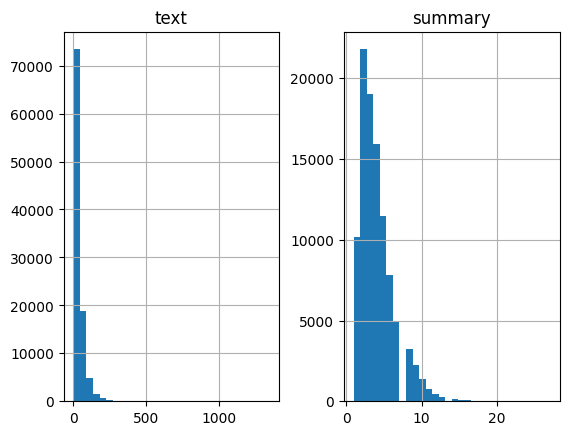

In [32]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [33]:
cnt=0
for i in df['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(df['cleaned_summary']))

0.9446629635189912


In [34]:
cleaned_text =np.array(df['cleaned_text'])
cleaned_summary=np.array(df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [35]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [36]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [38]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.53703317337784
Total Coverage of rare words: 2.473014833312864


Three different methods of tokenization:-
Choose only one of them best on the speed

In [84]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1


AttributeError: ignored

In [ ]:
x_voc

In [41]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

Reducing the x_voc_size could help us to remove the number of parameters in the embedding layers.
Taking the threshold of the rare words can help us remvoe the number of parameters.
Else we have to change the dataset to something smaller

In [42]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 76.36733383281602
Total Coverage of rare words: 4.8315313680911265


End of the tokenization method for x and begining of the tokenization of y
for y only one method is used so far and based on the performance of the x tokenization. One of the method is used.

In [43]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [75]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(48524, 47387)

In [44]:
type(y_tr)

numpy.ndarray

In [45]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [46]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [47]:
from keras import backend as K
K.clear_session()
latent_dim = 300
embedding_dim=100 #Keeping latent dimension to 300 and introducing embedding dimension of 100 to reduce the number of parameters of the model
#condider chaging the latent_dim to smaller value such as 100 or 300
#also adding a seperate embedding_dim can help to reduce the compleixity of the model

In [80]:
#encoder
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

NameError: ignored

In [49]:
#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [50]:
#decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

In [51]:
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])


In [52]:
#pip install attention_keras
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs,verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [53]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

In [54]:
# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [55]:
#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [56]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              897900    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 30, 300),            481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [57]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy') #using Adam optimizer instead of rms for better performance and efficieny in terms of speed

In [58]:
#using Early stoppage to stop the training of the model once the validation increasers

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [61]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=20,callbacks=[es],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/20
186/186 [==============================] - 128s 687ms/step - loss: 2.1551 - val_loss: 2.0549
Epoch 2/20
186/186 [==============================] - 105s 564ms/step - loss: 2.0916 - val_loss: 1.9995
Epoch 3/20
186/186 [==============================] - 104s 560ms/step - loss: 2.0321 - val_loss: 1.9496
Epoch 4/20
186/186 [==============================] - 101s 543ms/step - loss: 1.9724 - val_loss: 1.8937
Epoch 5/20
186/186 [==============================] - 101s 542ms/step - loss: 1.9168 - val_loss: 1.8440
Epoch 6/20
186/186 [==============================] - 102s 546ms/step - loss: 1.8510 - val_loss: 1.8118
Epoch 7/20
186/186 [==============================] - 103s 552ms/step - loss: 1.7998 - val_loss: 1.7696
Epoch 8/20
186/186 [==============================] - 110s 593ms/step - loss: 1.7510 - val_loss: 1.7362
Epoch 9/20
186/186 [==============================] - 101s 543ms/step - loss: 1.7095 - val_loss: 1.7203
Epoch 10/20
186/186 [==============================] - 101s 543m

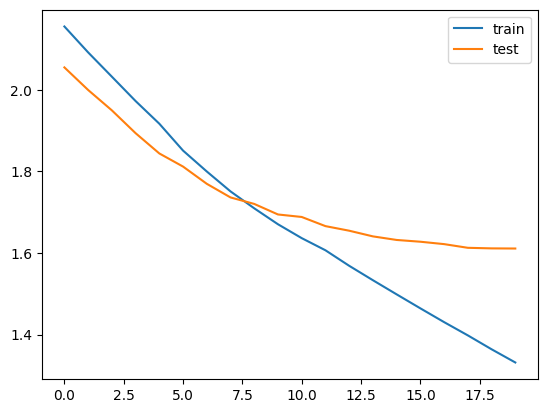

In [62]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [63]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [64]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [79]:
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

NameError: ignored

In [66]:
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

In [67]:
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])



In [68]:
#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [69]:
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

In [70]:
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [71]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [76]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [78]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: purchased favorite grandson difficult find glad amazon offers able get large selection packages flavors rich flavor little high calorie good issue 
Original summary: white chocolate mix 


NameError: ignored